# Setup

In [28]:
from dotenv import load_dotenv
env = load_dotenv()

In [29]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_openai import ChatOpenAI
from IPython.display import Image
import IPython

# Tools

In [30]:
from typing import TypedDict, Annotated, Dict, Any
import operator

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [4]:
%pip install pypdf

Note: you may need to restart the kernel to use updated packages.


In [31]:
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.pydantic_v1 import BaseModel, Field
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from bs4 import BeautifulSoup
from PyPDF2 import PdfReader
import tiktoken
import requests

# Healper method to read PDF files
def read_pdf(file_path) -> str:
    output = []
    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PdfReader(file)
            for page in pdf_reader.pages:
                output.append(page.extract_text())

        return output
        
    except Exception as e:
        print(f"Error reading PDF file: {e}")

# Search for relevant menu
search_tool = TavilySearchResults()

# Scrape menu data
class ScrapeInput(BaseModel):
    url: str = Field(description="the URL of the menu page")
    url: str = Field(description="the URL of the menu page")

@tool("scrape_pdf", args_schema=ScrapeInput, return_direct=True)
def scrape_pdf(url: str):
    """Scrape a webpage that may include links to a restaurants current menu and return the links"""
    pdf_links = []
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        links = soup.find_all('a')
        pdf_links = [link.get('href') for link in links if link.get('href').endswith('.pdf')]
    except Exception as e:
        print(f"failed to scrape {url} ERROR: {e}")
    return pdf_links

@tool("scrape_text", args_schema=ScrapeInput, return_direct=True)
def scrape_text(url: str):
    """Scrape the text directly from a website"""
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        # Remove script and style elements
        for script in soup(["script", "style"]):
            script.decompose()
        # Get text
        text = soup.get_text(separator=' ')
        # Break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # Break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # Drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)
    except Exception as e:
        print(f"failed to scrape {url} ERROR: {e}")
        return None
    return text

class DownloadInput(BaseModel):
    download_url: str = Field(description="the URL of the menu pdf")
    filename: str = Field(description="the name of the restaurants")

@tool("download-pdf", args_schema=DownloadInput, return_direct=True)
def download_pdf(download_url: str, filename: str):
    """Download a pdf file from a given url and filename"""
    response = urlopen(download_url)
    file = open("pdf/"+filename+".pdf", 'wb')
    file.write(response.read())
    file.close()

# Tokenize the pdf 
class upsertInput(BaseModel):
    file_path: str = Field(description="The filepath to the pdf in the format of pdf/filename.pdf")
    restaurant_name: str = Field(description="The name of the restaurant")
    location: str = Field(description="The location of the restaurant")


@tool("upsert-pdf", args_schema=upsertInput, return_direct=True)
def upsert_pdf(file_path, restaurant_name, location):
    """Upsert the pdf_file with metadata for vector search"""
    # Create the text splitter
    embeddings = OpenAIEmbeddings()
    text_splitter = SemanticChunker(embeddings, breakpoint_threshold_type="percentile")
    
    # Split the input text
    file = read_pdf(file_path)
    docs = text_splitter.create_documents(file)
    
    # Add metadata 
    metadata = {
        "name": restaurant_name,
        "location": location,
    }
    
    for doc in docs:
        doc.metadata = metadata
        
    # Point to our Pinecone index
    pc = Pinecone()
    index = pc.Index("paprika-ragu")
    
    # Upsert the data
    PineconeVectorStore.from_documents(docs, embeddings, index_name="paprika-ragu")

In [32]:
tools = [search_tool, scrape_pdf, scrape_text, download_pdf, upsert_pdf]

# RAG Model

In [37]:
class Model:
    # Define the model
    def __init__(self, model, tools, R_prompt="", G_prompt=""):
        self.R_prompt = R_prompt
        self.G_prompt = G_prompt
        
        graph = StateGraph(AgentState)
        
        graph.add_node("scrape_llm", self.openai_inference_scrape)
        graph.add_node("generate_llm", self.openai_inference_generate)
        graph.add_node("action", self.call_tool)
        
        # If the record already exists move to Augmentation + Generation
        # Else scrape the record with the Retrieval agent
        graph.add_conditional_edges(
            "generate_llm",
            self.exists_record,
            {True: "generate_llm", False: "scrape_llm"}
        )
        graph.add_conditional_edges(
            "scrape_llm",
            self.requires_tool,
            {True: "action", False: "generate_llm"}
        )
        
        graph.add_edge("action", "scrape_llm")
        graph.set_entry_point("generate_llm")
        
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_record(self, state: AgentState):
        # if the current menu is already in the vector database
        # move to the augmentation step 
        return False

    
    # Check if llm requires action 
    def requires_tool(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
        
    # Run a tool ordered by the model
    def call_tool(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}
    
    # Invokes the current message chain
    def openai_inference_scrape(self, state: AgentState):
        messages = state['messages']
        if self.R_prompt:
            messages = [SystemMessage(content=self.R_prompt)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def openai_inference_generate(self, state: AgentState):
        messages = state['messages']
        if self.G_prompt:
            messages = [SystemMessage(content=self.G_prompt)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

In [34]:
retrieval_prompt = """
You are tasked with searching for a given restaurant menu, downloading the menu, and the upserting the menu to a vector database. 
----------
You will first search for the restaurant menu, you will either download the PDF file or scrape the text directly from the page if a PDF is not available.
ONLY scrape menu data, this includes foods that the restaurant offers and DOES NOT include information about the restaurant itself or the menu iteself.
Use the search tool to find the url of the menu, if you cannot find the pdf url directly use the scrape_pdf tool to scrape webpages for the url.
---------
Once you have downloaded or scraped the menu, you will then upsert it into our vector database. 
You will provide links to the pdf_file holding the menu, aswell as the name of the restaurant and the location of the restaurant.
---------
"""

generation_prompt = """
You are tasked with searching for a given restaurant menu, downloading the menu, and the upserting the menu to a vector database. 
----------
You will first search for the restaurant menu, you will either download the PDF file or scrape the text directly from the page if a PDF is not available.
ONLY scrape menu data, this includes foods that the restaurant offers and DOES NOT include information about the restaurant itself or the menu iteself.
Use the search tool to find the url of the menu, if you cannot find the pdf url directly use the scrape_pdf tool to scrape webpages for the url.
---------
Once you have downloaded or scraped the menu, you will then upsert it into our vector database. 
You will provide links to the pdf_file holding the menu, aswell as the name of the restaurant and the location of the restaurant.
---------
"""

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
)

model = Model(llm, tools, R_prompt=retrieval_prompt, G_prompt=generation_prompt)

In [35]:
messages = ["CRISP Rochester"]
result = model.graph.invoke({"messages": messages})

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_wG9EDiWLJPL2RPXfh8rgCU88", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

In [78]:
result

{'messages': ['CRISP Rochester',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rBj9wXpQ2VuuLw08yBhsgi3A', 'function': {'arguments': '{"query":"CRISP Rochester menu"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 431, 'total_tokens': 452}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3cd8b62c3b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2591be5c-a46e-4dd2-a2c6-602f671d0efc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'CRISP Rochester menu'}, 'id': 'call_rBj9wXpQ2VuuLw08yBhsgi3A', 'type': 'tool_call'}], usage_metadata={'input_tokens': 431, 'output_tokens': 21, 'total_tokens': 452}),
  ToolMessage(content="[{'url': 'https://crisprochester.com/menus/', 'content': 'CRISP Rochester menus. Lunch, dinner, cocktails, wine, beer, and brunch menus. Skip to content. 819 S. Clinton Ave. Rochester, NY. 14620 +1 (585) 978-

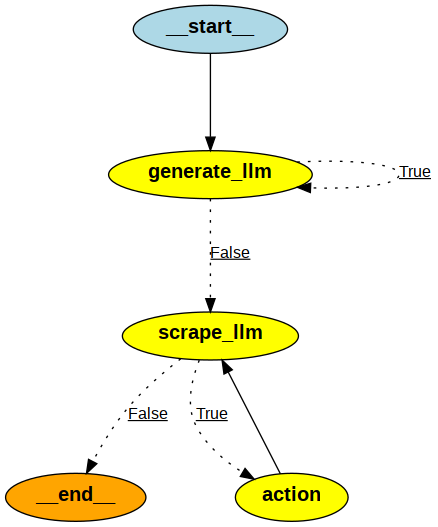

In [38]:
import pygraphviz
Image(model.graph.get_graph().draw_png())

# Datastore

In [90]:
%pip install --upgrade --quiet  \
    langchain-pinecone \
    langchain-openai \
    langchain \
    langchain-community \
    pinecone-notebooks

Note: you may need to restart the kernel to use updated packages.


In [23]:
from PyPDF2 import PdfReader

def read_pdf(file_path) -> str:
    output = []
    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PdfReader(file)
            for page in pdf_reader.pages:
                output.append(page.extract_text())

        return output
        
    except Exception as e:
        print(f"Error reading PDF file: {e}")

# Replace 'your_pdf_file.pdf' with the path to your PDF file
file = read_pdf('pdf/menu.pdf')

In [24]:
docs = text_splitter_semantic.create_documents(file)

In [25]:
embeddings = OpenAIEmbeddings()

In [27]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone()

In [23]:
import time

index_name = "paprika-ragu"

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)

In [24]:
from langchain_pinecone import PineconeVectorStore

docsearch = PineconeVectorStore.from_documents(docs, embeddings, index_name=index_name)

In [1]:
query = "Does CRISP Rochester fit a vegan diet?"
docs = docsearch.similarity_search(query)
print(docs[0].page_content)

NameError: name 'docsearch' is not defined